Dataset
Total number of images: 22495.

Training set size: 16854 images (one fruit or vegetable per image).

Test set size: 5641 images (one fruit or vegetable per image).

Number of classes: 33 (fruits and vegetables).

Image size: 100x100 pixels.

Training data filename format: [fruit/vegetable name][id].jpg (e.g. Apple Braeburn100.jpg). Many images are also rotated, to help training.

Testing data filename format: [4 digit id].jpg (e.g. 0001.jpg)



In [1]:
from IPython.display import HTML, display, clear_output

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [3]:
# from google.colab import drive
# drive.mount("/drive")

In [4]:
data_dir = './content/dataset'

In [5]:
# !unzip "/content/drive/MyDrive/НБУ/Семестър 2/Прогнозиране чрез анализ на данни - II част. Невронни мрежи/Exam 2/dataset.zip" -d "/content/dataset"
# clear_output()

In [6]:
# Move files in correct dirs
if os.path.exists(data_dir + "/train/train") == True:

    original_train_filenames = os.listdir(data_dir + "/train/train")

    for filename in original_train_filenames:
        os.rename(f"{data_dir}/train/train/{filename}", f"{data_dir}/train/{filename}")

    import shutil

    try:
        shutil.rmtree(f'{data_dir}/train/train')
    except:
        pass

In [7]:
TRAIN = 'train'
TEST = 'test'

In [8]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets[TRAIN] = Subset(dataset, train_idx)
    datasets[TEST] = Subset(dataset, val_idx)
    return datasets

In [9]:
search_for_images_in = [
  TRAIN,
  TEST
]

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.ToTensor(),
    ])
}

whole_dataset = datasets.ImageFolder('./content/dataset/train', transform=transforms.Compose([transforms.ToTensor()]))
image_datasets = train_val_dataset(whole_dataset)
print("Total train size: ", len(image_datasets[TRAIN]))
print("Total test size: ", len(image_datasets[TEST]))

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in search_for_images_in
}

dataset_sizes = {x: len(image_datasets[x]) for x in search_for_images_in}

for x in search_for_images_in:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].dataset.classes
print(image_datasets[TRAIN].dataset.classes)

Total train size:  12640
Total test size:  4214
Loaded 12640 images under train
Loaded 4214 images under test
Classes: 
['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


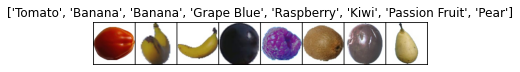

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [11]:
def visualize_model(vgg, num_images=6, type_of_data=TEST):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[type_of_data]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [12]:
def eval_model(vgg, criterion, type_of_data=TEST):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[type_of_data])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[type_of_data]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # loss_test += loss.data[0]
        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[type_of_data]
    avg_acc = acc_test / dataset_sizes[type_of_data]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

## Model creation

The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load(f"./vgg16_bn.pth/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [14]:
list(vgg16.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=33, bias=True)]

In [15]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('VGG16_v2-Fruit-Classifier.pt'))
    print("Loaded!")

Loading pretrained model..
Loaded!


In [16]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
print("Test before training")
# eval_model(vgg16, criterion, TEST)

Test before training


C:\Users\nikiv\AppData\Local\Temp\ipykernel_4144\2249034668.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Ground truth:


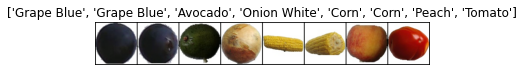

Prediction:


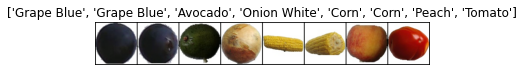

In [19]:
visualize_model(vgg16) #test before training

In [20]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            # loss_train += loss.data[0]
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        best_model_wts = copy.deepcopy(vgg.state_dict())
        # if avg_acc_val > best_acc:
        #     best_acc = avg_acc_val
        #     best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [21]:
# vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2) # Uncomment to train the model
# torch.save(vgg16.state_dict(), 'VGG16_v2-Fruit-Classifier.pt') # Uncomment to train the model

In [22]:
vgg16.load_state_dict(torch.load(f"VGG16_v2-Fruit-Classifier.pt"))

<All keys matched successfully>

In [23]:
vgg16.training

False

In [ ]:
# eval_model(vgg16, criterion, TEST) # Uncomment to evaluate the model

Evaluating model
----------
Test batch 0/527

C:\Users\nikiv\AppData\Local\Temp\ipykernel_1324\1126835276.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Test batch 500/527
Evaluation completed in 2m 58s
Avg loss (test): 0.0000
Avg acc (test): 1.0000
----------


C:\Users\nikiv\AppData\Local\Temp\ipykernel_4144\2249034668.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Ground truth:


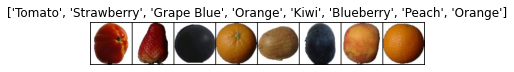

Prediction:


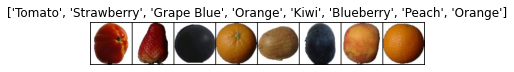

In [24]:
visualize_model(vgg16, num_images=1, type_of_data=TEST)